# Streaming Anomaly Detection for the Cod-RNA dataset

H. Huang and S. Kasiviswanathan, "**Streaming Anomaly Detection Using Randomized Matrix Sketching**," http://bit.ly/1FaDw6S.

In [3]:
import numpy as np
import numpy.linalg as ln
import pandas as pd
import sklearn.metrics as met
import sklearn.preprocessing as preprocessing
import sys
import time
from os.path import expanduser
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
%load_ext autoreload
%autoreload 2
from stream_anomaly_detector import GlobalUpdate, RandomizedSketchUpdate, SketchUpdate

## Data preparation

CodRNA dataset is available: https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html

In [48]:
def read_CodRNA(path):
    """
    Read Cod-RNA dataset with given path
    Data format:
        label 1:xxx 2:xxx 3:xxx ... 8:xxx
    """
    X = []
    y = []

    with open(expanduser(path)) as f:
        lines = f.readlines()
        for line in lines:
            l = line.rstrip().split(' ')
            y.append(int(l[0]))
            x = []
            for i in range(1, 9): # 8 features in total
                x.append(float(l[i][2:]))
            X.append(x)
    
    return np.asarray(X).T, np.asarray(y)

## Anomaly detection

In [44]:
def show_result(y_true, y_pred, y_score):
    print('precision = %f' % met.precision_score(y_true, y_pred))
    print('recall = %f' % met.recall_score(y_true, y_pred))
    print('F1 = %f' % met.f1_score(y_true, y_pred))
    
    fpr, tpr, _ = met.roc_curve(y_true, y_score)

    print('AUC = %f' % met.auc(fpr, tpr))

    fig, ax = plt.subplots()
    ax.plot(fpr, tpr, marker='o', mew=0., markersize=2.)
    ax.plot([0, 1], [0, 1], 'k--')

    ax.set_xlabel('FP')
    ax.set_ylabel('TP')
    ax.grid(True)

    fig.set_size_inches((5.5, 3))
    fig.patch.set_alpha(0.0)

In [30]:
def experiment_p(_training_samples, _testing_samples, _testing_labels, prior_anomaly_rate, algoNum):
    
    # initialize and train anomaly detector
    # percentage of anomalies (0.33) is given as a prior knowledge
    
    if algoNum == 1:   
        detector = GlobalUpdate(_training_samples, criterion='p', criterion_v=prior_anomaly_rate)
#         detector = GlobalUpdate(_training_samples, criterion='p', criterion_v=0.1)
#         detector = GlobalUpdate(_training_samples)
    elif algoNum == 2:
        detector = RandomizedSketchUpdate(_training_samples, criterion='p', criterion_v=prior_anomaly_rate)
#         detector = RandomizedSketchUpdate(_training_samples, criterion='p', criterion_v=0.1)
#         detector = RandomizedSketchUpdate(_training_samples)
    elif algoNum == 3:
        detector = SketchUpdate(_training_samples, criterion='p', criterion_v=prior_anomaly_rate)
#         detector = SketchUpdate(_training_samples, criterion='p', criterion_v=0.1)
#         detector = SketchUpdate(_training_samples)

    n_test = _testing_samples.shape[1]
    
    print('Test on %d samples:' % n_test)
    
    y_true = np.array([])
    y_pred = np.array([])
    y_score = np.array([])
    
    s_time = 0.
    n = 0
    
    # number of data points in each timestep is set to 5000
    head = 0
    step = 5000
    while head < n_test:
        tail = head + step
        
        sys.stdout.write('\rTime %3d: [%d, %d]' % (n + 1, head, tail - 1))
        sys.stdout.flush()
        
        testing_samples_epoch = _testing_samples[:, head:tail]
        testing_labels_epoch = _testing_labels[head:tail]
        
        # save true labels
#         y_true = np.append(y_true, y[test_indices[head:tail]])
        y_true = np.append(y_true, testing_labels_epoch)
        
        # anomaly detection results
        start = time.process_time() 
#         anomaly_indices, normal_indices, scores = detector.detect(X[:, test_indices[head:tail]])
        anomaly_indices, normal_indices, scores = detector.detect(testing_samples_epoch)
        s_time += (time.process_time() - start)
        
        # probability that a sample is anomaly {0, 1}
        tmp = np.zeros(anomaly_indices.size + normal_indices.size)
        tmp[anomaly_indices] = 1.
        y_pred = np.append(y_pred, tmp)
        
        # anomaly score directly corresponds to confidence of prediction
        y_score = np.append(y_score, scores)
                
        n += 1
        head = tail
    
    y_true = y_true.astype(int) # {-1, 1} in integer
        
    sys.stdout.write('\rAvg. detect + update time per timestep = %f [sec]' % (s_time / n))
    sys.stdout.flush()
    
    return y_true, y_pred, y_score

In [31]:
def ADMES(training_samples, testing_samples, training_labels, testing_labels, _algoNum):
    dataSet = np.hstack((training_labels, testing_labels))
    prior_anomaly_rate = round(np.where(dataSet == 1)[0].size/dataSet.size, 4)
    _y_true, _y_pred, _score = experiment_p(training_samples, testing_samples, testing_labels, prior_anomaly_rate, _algoNum)
    return _y_true, _y_pred, _score

In [32]:
def runADMES(training_samples, training_labels, testing_samples, testing_labels, algoNum, _train_test_range):
    
    _train_start = 0
    _test_start = 0

    _coll_y_true = []
    _coll_y_pred = []
    _coll_score = []

    for _train_test in _train_test_range:

        _train_step = _train_test[0]
        _test_step = _train_test[1]

        _training_samples = np.transpose(training_samples[_train_start:_train_start+_train_step])
        _training_labels = np.transpose(training_labels[_train_start:_train_start+_train_step])

        _testing_samples = np.transpose(testing_samples[_test_start:_test_start+_test_step])
        _testing_labels = np.transpose(testing_labels[_test_start:_test_start+_test_step])

        _train_start += _train_step
        _test_start += _test_step

        _y_true, _y_pred, _score = ADMES(_training_samples, _testing_samples, _training_labels, _testing_labels, algoNum)
        _coll_y_true.extend(_y_true)
        _coll_y_pred.extend(_y_pred)
        _coll_score.extend(_score)
    return np.array(_coll_y_true), np.array(_coll_y_pred), np.array(_coll_score)

##### Each activity is represented by a 46-D vector in which the first 24-D describes the time information and the following 22-D carries out the type information.

In [267]:
training_samples = np.load("./baselines/training_samples.npy")
training_labels = np.load("./baselines/training_labels.npy")
testing_samples = np.load("./baselines/testing_samples.npy")
testing_labels = np.load("./baselines/testing_labels.npy")
train_test_range = np.array([[3137, 28233],[3775,  33979],[6198,  55791],[4243,  38195],
                            [2096,  18868],[4501,  40514],[1494,  13449],[3760,  33842],
                            [461,  4149],[461,  4150]])

#### Alg. 2: Global Update

In [268]:
y_true, y_pred, scores = runADMES(training_samples, training_labels, testing_samples, testing_labels, 1, train_test_range)

Test on 28233 samples:
Avg. detect + update time per timestep = 0.148689 [sec]Test on 33979 samples:
Avg. detect + update time per timestep = 0.133860 [sec]Test on 55791 samples:
Avg. detect + update time per timestep = 0.117338 [sec]Test on 38195 samples:
Avg. detect + update time per timestep = 0.128888 [sec]Test on 18868 samples:
Avg. detect + update time per timestep = 0.131016 [sec]Test on 40514 samples:
Avg. detect + update time per timestep = 0.119278 [sec]Test on 13449 samples:
Avg. detect + update time per timestep = 0.127451 [sec]Test on 33842 samples:
Avg. detect + update time per timestep = 0.123884 [sec]Test on 4149 samples:
Avg. detect + update time per timestep = 0.113528 [sec]Test on 4150 samples:
Avg. detect + update time per timestep = 0.098200 [sec]

precision = 0.008557
recall = 0.551069
F1 = 0.016853
AUC = 0.762617


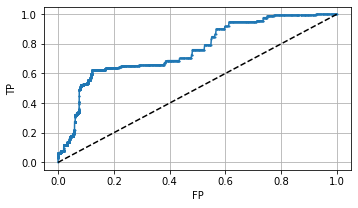

In [269]:
show_result(y_true, y_pred, scores)

In [256]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=["0", "1"]))

              precision    recall  f1-score   support

           0       1.00      0.90      0.95    270749
           1       0.01      0.55      0.02       421

    accuracy                           0.90    271170
   macro avg       0.50      0.73      0.48    271170
weighted avg       1.00      0.90      0.95    271170



In [257]:
np.save("./baselines/Global_new_3",scores)

#### Alg. 3: Randmized Sketch Update

In [258]:
y_true, y_pred, scores = runADMES(training_samples, training_labels, testing_samples, testing_labels, 2, train_test_range)

Test on 28233 samples:
Avg. detect + update time per timestep = 0.141589 [sec]Test on 33979 samples:
Avg. detect + update time per timestep = 0.140959 [sec]Test on 55791 samples:
Avg. detect + update time per timestep = 0.130816 [sec]Test on 38195 samples:
Avg. detect + update time per timestep = 0.136155 [sec]Test on 18868 samples:
Avg. detect + update time per timestep = 0.135064 [sec]Test on 40514 samples:
Avg. detect + update time per timestep = 0.141806 [sec]Test on 13449 samples:
Avg. detect + update time per timestep = 0.142802 [sec]Test on 33842 samples:
Avg. detect + update time per timestep = 0.146812 [sec]Test on 4149 samples:
Avg. detect + update time per timestep = 0.173438 [sec]Test on 4150 samples:
Avg. detect + update time per timestep = 0.161454 [sec]

precision = 0.008041
recall = 0.517815
F1 = 0.015836
AUC = 0.785351


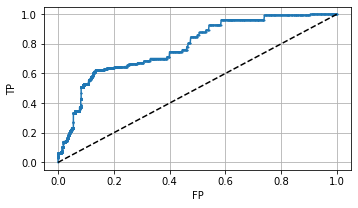

In [259]:
show_result(y_true, y_pred, scores)

In [260]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=["0", "1"]))

              precision    recall  f1-score   support

           0       1.00      0.90      0.95    270749
           1       0.01      0.52      0.02       421

    accuracy                           0.90    271170
   macro avg       0.50      0.71      0.48    271170
weighted avg       1.00      0.90      0.95    271170



In [261]:
np.save("./baselines/ADeMS_new_3", scores)

#### Alg. 4: Sketch Update

In [262]:
y_true, y_pred, scores = runADMES(training_samples, training_labels, testing_samples, testing_labels, 3, train_test_range)

Test on 28233 samples:
Avg. detect + update time per timestep = 0.134028 [sec]Test on 33979 samples:
Avg. detect + update time per timestep = 0.118309 [sec]Test on 55791 samples:
Avg. detect + update time per timestep = 0.103568 [sec]Test on 38195 samples:
Avg. detect + update time per timestep = 0.109321 [sec]Test on 18868 samples:
Avg. detect + update time per timestep = 0.107343 [sec]Test on 40514 samples:
Avg. detect + update time per timestep = 0.097522 [sec]Test on 13449 samples:
Avg. detect + update time per timestep = 0.116176 [sec]Test on 33842 samples:
Avg. detect + update time per timestep = 0.101331 [sec]Test on 4149 samples:
Avg. detect + update time per timestep = 0.101684 [sec]Test on 4150 samples:
Avg. detect + update time per timestep = 0.083652 [sec]

precision = 0.008041
recall = 0.517815
F1 = 0.015836
AUC = 0.785351


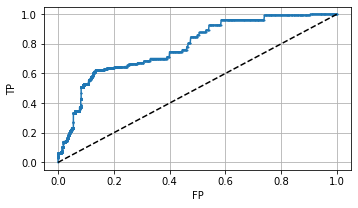

In [263]:
show_result(y_true, y_pred, scores)

In [264]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=["0", "1"]))

              precision    recall  f1-score   support

           0       1.00      0.90      0.95    270749
           1       0.01      0.52      0.02       421

    accuracy                           0.90    271170
   macro avg       0.50      0.71      0.48    271170
weighted avg       1.00      0.90      0.95    271170



In [265]:
np.save("./baselines/RandADeMS_new_3.npy",scores)

##### On wiki-dataset.

In [2]:
import numpy as np

##### dataset description
    - Feature: each record, a two-dimension vector, describes one editing activity in which the first dimension indicates the exact editing physical time and the second one denotes the page type which is being edited, a regular page or a meta one.
    - Label: if the page editing is revertd later, this editing activity is marked as malicious(1); otherwise, it will be labelled as normal(0). 

In [110]:
metroSystem = np.load("./data/Wiki_dataset/wiki/List_of_metro_systems.npy")
louisCardinals = np.load("./data/Wiki_dataset/wiki/St._Louis_Cardinals.npy")
starTrekIntoDarkness = np.load("./data/Wiki_dataset/wiki/Star_Trek_Into_Darkness.npy")
metroSystemLabel = np.load("./data/Wiki_dataset/wiki_label/label_List_of_metro_systems.npy")
louisCardinalsLabel = np.load("./data/Wiki_dataset/wiki_label/label_St._Louis_Cardinals.npy")
starTrekIntoDarknessLabel = np.load("./data/Wiki_dataset/wiki_label/label_Star_Trek_Into_Darkness.npy")

In [111]:
train_test_range = []
train_test_range.append([int(metroSystem.shape[0]/10), metroSystem.shape[0]-int(metroSystem.shape[0]/10)])
train_test_range.append([int(louisCardinals.shape[0]/10), louisCardinals.shape[0]-int(louisCardinals.shape[0]/10)])
train_test_range.append([int(starTrekIntoDarkness.shape[0]/10), starTrekIntoDarkness.shape[0]-int(starTrekIntoDarkness.shape[0]/10)])

In [112]:
train_test_range = np.array(train_test_range)

In [113]:
train_test_range

array([[ 39, 357],
       [ 33, 304],
       [ 41, 378]])

In [114]:
training_samples = []
training_labels = []
testing_samples = []
testing_labels = []

In [115]:
training_samples.extend(metroSystem[:train_test_range[0][0]])
training_labels.extend(metroSystemLabel[:train_test_range[0][0]])
testing_samples.extend(metroSystem[train_test_range[0][0]:])
testing_labels.extend(metroSystemLabel[train_test_range[0][0]:])

training_samples.extend(louisCardinals[:train_test_range[1][0]])
training_labels.extend(louisCardinalsLabel[:train_test_range[1][0]])
testing_samples.extend(louisCardinals[train_test_range[1][0]:])
testing_labels.extend(louisCardinalsLabel[train_test_range[1][0]:])

training_samples.extend(starTrekIntoDarkness[:train_test_range[2][0]])
training_labels.extend(starTrekIntoDarknessLabel[:train_test_range[2][0]])
testing_samples.extend(starTrekIntoDarkness[train_test_range[2][0]:])
testing_labels.extend(starTrekIntoDarknessLabel[train_test_range[2][0]:])

In [116]:
training_samples, training_labels, testing_samples, testing_labels = np.array(training_samples), np.array(training_labels), np.array(testing_samples), np.array(testing_labels)

In [117]:
training_samples.shape, training_labels.shape, testing_samples.shape, testing_labels.shape

((113, 2), (113,), (1039, 2), (1039,))

In [118]:
def oneHotEncoding(X, dim, _type=None):
    X_enc = []
    for _x in X:
        _x_enc = np.zeros((dim,), dtype=int)
        if _type == 'time':
            oneHotInd = datetime.utcfromtimestamp(_x).hour
        else:
            oneHotInd = int(_x)
        _x_enc[oneHotInd] = 1
        X_enc.append(_x_enc.tolist())
    return np.array(X_enc)

In [119]:
_train_act_info = oneHotEncoding(training_samples[:,1], 2)
_train_time_info = oneHotEncoding(training_samples[:,0], 24, 'time')
training_samples = np.concatenate((_train_act_info, _train_time_info), axis=1)

In [120]:
_test_act_info = oneHotEncoding(testing_samples[:,1], 2)
_test_time_info = oneHotEncoding(testing_samples[:,0], 24, 'time')
testing_samples = np.concatenate((_test_act_info, _test_time_info), axis=1)

In [121]:
training_samples.shape, testing_samples.shape

((113, 26), (1039, 26))

In [123]:
y_true, y_pred, scores = runADMES(training_samples, training_labels, testing_samples, testing_labels, 1, train_test_range)

Test on 357 samples:
Avg. detect + update time per timestep = 0.027938 [sec]Test on 304 samples:
Avg. detect + update time per timestep = 0.032174 [sec]Test on 378 samples:
Avg. detect + update time per timestep = 0.033666 [sec]

precision = 0.384615
recall = 0.434783
F1 = 0.408163
AUC = 0.752204


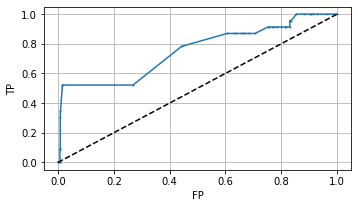

In [124]:
show_result(y_true, y_pred, scores)

In [125]:
np.save("./baselines/Global_wiki",scores)

In [126]:
y_true, y_pred, scores = runADMES(training_samples, training_labels, testing_samples, testing_labels, 2, train_test_range)

Test on 357 samples:
Avg. detect + update time per timestep = 0.145560 [sec]Test on 304 samples:
Avg. detect + update time per timestep = 0.040538 [sec]Test on 378 samples:
Avg. detect + update time per timestep = 0.037374 [sec]

precision = 0.384615
recall = 0.434783
F1 = 0.408163
AUC = 0.752075


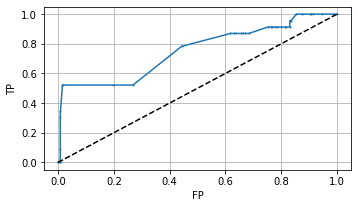

In [127]:
show_result(y_true, y_pred, scores)

In [128]:
np.save("./baselines/ADeMS_wiki", scores)

In [129]:
y_true, y_pred, scores = runADMES(training_samples, training_labels, testing_samples, testing_labels, 3, train_test_range)

Test on 357 samples:
Avg. detect + update time per timestep = 0.028390 [sec]Test on 304 samples:
Avg. detect + update time per timestep = 0.030652 [sec]Test on 378 samples:
Avg. detect + update time per timestep = 0.036640 [sec]

precision = 0.384615
recall = 0.434783
F1 = 0.408163
AUC = 0.752204


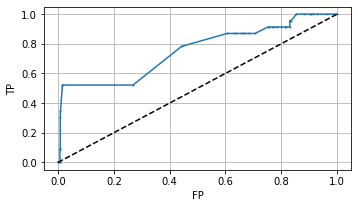

In [130]:
show_result(y_true, y_pred, scores)

In [131]:
np.save("./baselines/RandADeMS_wiki.npy",scores)

##### Iso forest

In [17]:
import os
import sys
import numpy as np
import time
import json
import random
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from collections import defaultdict
from matplotlib.pyplot import axvline
import math
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
from inspect import signature
from collections import Counter, defaultdict
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
import pickle
import datetime
import seaborn as sns

In [132]:
training_samples.shape, testing_samples.shape

((113, 26), (1039, 26))

In [133]:
clf_isolationforest = IsolationForest()

In [134]:
# training_samples = np.load("./baselines/training_samples.npy")
clf_isolationforest.fit(training_samples)

/Users/panpanzheng/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/panpanzheng/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


IsolationForest(behaviour='old', bootstrap=False, contamination='legacy',
                max_features=1.0, max_samples='auto', n_estimators=100,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)

In [135]:
# testing_samples = np.load("./baselines/testing_samples.npy")
wiki_oppo_iso_score_90 = clf_isolationforest.score_samples(testing_samples)

In [136]:
np.save("./baselines/wiki_oppo_iso_score_90", wiki_oppo_iso_score_90)

#####  Local outlier

In [137]:
clf_localoutlierfactor = LocalOutlierFactor(n_neighbors=20, contamination=0.1, novelty=True)

In [138]:
clf_localoutlierfactor.fit(training_samples)

LocalOutlierFactor(algorithm='auto', contamination=0.1, leaf_size=30,
                   metric='minkowski', metric_params=None, n_jobs=None,
                   n_neighbors=20, novelty=True, p=2)

In [139]:
wiki_oppo_local_score_90 = clf_localoutlierfactor.decision_function(testing_samples)

In [140]:
np.save("./baselines/wiki_oppo_local_score_90", wiki_oppo_local_score_90)

In [141]:
np.save("./baselines/wiki_testing_labels", testing_labels)